# DragonNet

__Reference__: [Claudia Shi et al, Adapting Neural Networks for the Estimation of Treatment Effects, NeurIPS 2019](https://arxiv.org/pdf/1906.02120v2.pdf)

__Implementation remarks__: our implementation is exactly the same of the original paper with the exception 
    of a _sklearn.preprocessing.StandardScaler_ which was originally used to scale predictions. 

## DragonNet on IHDP 

In [1]:
from causalforge.model import Model , PROBLEM_TYPE
from causalforge.data_loader import DataLoader 

# load IHDP dataset 
r = DataLoader.get_loader('IHDP').load()
X_tr, T_tr, YF_tr, YCF_tr, mu_0_tr, mu_1_tr, X_te, T_te, YF_te, YCF_te, mu_0_te, mu_1_te = r

# model 
params={}
params['input_dim'] = X_tr.shape[1] 
    
    
dragonnet = Model.create_model("dragonnet",
                               params,
                               problem_type=PROBLEM_TYPE.CAUSAL_TREATMENT_EFFECT_ESTIMATION, 
                               multiple_treatments=False)

dragonnet.model.summary()

2023-05-08 11:27:39.405731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 25)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          5200        ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 200)          40200       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 200)          40200       ['dense_1[0][0]']                
                                                                                              

2023-05-08 11:27:46.635666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 concatenate (Concatenate)      (None, 4)            0           ['y0_predictions[0][0]',         
                                                                  'y1_predictions[0][0]',         
                                                                  'dense_3[0][0]',                
                                                                  'epsilon_layer[0][0]']          
                                                                                                  
Total params: 146,404
Trainable params: 146,404
Non-trainable params: 0
__________________________________________________________________________________________________


In [2]:
from causalforge.metrics import eps_ATE_diff, PEHE_with_ite
import numpy as np

experiment_ids = [1,10,400]

eps_ATE_tr, eps_ATE_te = [], []
eps_PEHE_tr, eps_PEHE_te = [] , [] 



for idx in experiment_ids:    
    t_tr, y_tr, x_tr, mu0tr, mu1tr = T_tr[:,idx] , YF_tr[:,idx], X_tr[:,:,idx], mu_0_tr[:,idx], mu_1_tr[:,idx] 
    t_te, y_te, x_te, mu0te, mu1te = T_te[:,idx] , YF_te[:,idx], X_te[:,:,idx], mu_0_te[:,idx], mu_1_te[:,idx]  
    
    
    # Train your causal method on train-set ...
    dragonnet.fit(x_tr,t_tr,y_tr)

    # Validate your method test-set ... 
    ATE_truth_tr = (mu1tr - mu0tr).mean()
    ATE_truth_te = (mu1te - mu0te).mean()
    
    ITE_truth_tr = (mu1tr - mu0tr)
    ITE_truth_te = (mu1te - mu0te)
    
    eps_ATE_tr.append( eps_ATE_diff( dragonnet.predict_ite(x_tr), ITE_truth_tr) )
    eps_ATE_te.append( eps_ATE_diff( dragonnet.predict_ite(x_te), ITE_truth_te) )
    
    eps_PEHE_tr.append( PEHE_with_ite( dragonnet.predict_ite(x_tr), ITE_truth_tr, sqrt=True))
    eps_PEHE_te.append( PEHE_with_ite( dragonnet.predict_ite(x_te), ITE_truth_te , sqrt=True))
        

Epoch 1/30


/Users/AG62216/opt/anaconda3/envs/causalforge/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


9/9 [==============================] - 2s 45ms/step - loss: 1933.4249 - regression_loss: 889.4026 - binary_classification_loss: 40.9478 - treatment_accuracy: 0.5728 - track_epsilon: 0.0388 - val_loss: 867.6917 - val_regression_loss: 296.2574 - val_binary_classification_loss: 29.3260 - val_treatment_accuracy: 0.8006 - val_track_epsilon: 0.0409 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - 0s 6ms/step - loss: 475.6049 - regression_loss: 207.7449 - binary_classification_loss: 35.2396 - treatment_accuracy: 0.8106 - track_epsilon: 0.0398 - val_loss: 456.4780 - val_regression_loss: 154.8738 - val_binary_classification_loss: 22.1945 - val_treatment_accuracy: 0.8006 - val_track_epsilon: 0.0395 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 351.8539 - regression_loss: 148.4498 - binary_classification_loss: 30.6420 - treatment_accuracy: 0.8069 - track_epsilon: 0.0401 - val_loss: 332.7174 - val_regression_loss: 109.1477 - val_binary_classificat

/Users/AG62216/opt/anaconda3/envs/causalforge/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


9/9 [==============================] - 1s 40ms/step - loss: 167.7855 - regression_loss: 64.8438 - binary_classification_loss: 27.2506 - treatment_accuracy: 0.8024 - track_epsilon: 0.0282 - val_loss: 158.2424 - val_regression_loss: 46.7677 - val_binary_classification_loss: 19.8218 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0261 - lr: 1.0000e-05
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 169.2044 - regression_loss: 65.5163 - binary_classification_loss: 27.2438 - treatment_accuracy: 0.8078 - track_epsilon: 0.0213 - val_loss: 157.5997 - val_regression_loss: 46.4904 - val_binary_classification_loss: 19.8502 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0207 - lr: 1.0000e-05
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 167.3798 - regression_loss: 65.1597 - binary_classification_loss: 27.2209 - treatment_accuracy: 0.7997 - track_epsilon: 0.0210 - val_loss: 159.6340 - val_regression_loss: 47.7414 - val_binary_classifi

9/9 [==============================] - 0s 5ms/step - loss: 162.9465 - regression_loss: 62.6070 - binary_classification_loss: 26.9913 - treatment_accuracy: 0.8024 - track_epsilon: 0.0056 - val_loss: 155.2802 - val_regression_loss: 46.0902 - val_binary_classification_loss: 19.8175 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0047 - lr: 5.0000e-06
Epoch 23/100
9/9 [==============================] - 0s 5ms/step - loss: 164.0407 - regression_loss: 62.5670 - binary_classification_loss: 26.9810 - treatment_accuracy: 0.7970 - track_epsilon: 0.0043 - val_loss: 154.8385 - val_regression_loss: 45.9068 - val_binary_classification_loss: 19.8235 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0045 - lr: 5.0000e-06
Epoch 24/100
1/9 [==>...........................] - ETA: 0s - loss: 164.1371 - regression_loss: 64.0276 - binary_classification_loss: 31.0431 - treatment_accuracy: 0.7812 - track_epsilon: 0.0045
Epoch 24: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

9/9 [==============================] - 0s 5ms/step - loss: 162.1253 - regression_loss: 61.9840 - binary_classification_loss: 26.9126 - treatment_accuracy: 0.7988 - track_epsilon: 0.0045 - val_loss: 155.5521 - val_regression_loss: 46.1789 - val_binary_classification_loss: 19.8315 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0046 - lr: 1.2500e-06
Epoch 43/100
9/9 [==============================] - 0s 5ms/step - loss: 161.1642 - regression_loss: 61.8416 - binary_classification_loss: 26.9129 - treatment_accuracy: 0.8069 - track_epsilon: 0.0049 - val_loss: 156.7784 - val_regression_loss: 46.6084 - val_binary_classification_loss: 19.8280 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0052 - lr: 6.2500e-07
Epoch 44/100
9/9 [==============================] - 0s 5ms/step - loss: 162.5076 - regression_loss: 61.8267 - binary_classification_loss: 26.9117 - treatment_accuracy: 0.8123 - track_epsilon: 0.0052 - val_loss: 156.4902 - val_regression_loss: 46.5072 - val_binary_classif

9/9 [==============================] - 0s 6ms/step - loss: 161.2802 - regression_loss: 61.6652 - binary_classification_loss: 26.9017 - treatment_accuracy: 0.8015 - track_epsilon: 0.0047 - val_loss: 155.7152 - val_regression_loss: 46.2360 - val_binary_classification_loss: 19.8310 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0047 - lr: 7.8125e-08
Epoch 63/100
9/9 [==============================] - 0s 7ms/step - loss: 162.1019 - regression_loss: 61.6727 - binary_classification_loss: 26.9014 - treatment_accuracy: 0.8096 - track_epsilon: 0.0047 - val_loss: 155.6357 - val_regression_loss: 46.2089 - val_binary_classification_loss: 19.8310 - val_treatment_accuracy: 0.7954 - val_track_epsilon: 0.0047 - lr: 7.8125e-08
Epoch 64/100
9/9 [==============================] - 0s 7ms/step - loss: 162.6298 - regression_loss: 61.6724 - binary_classification_loss: 26.9014 - treatment_accuracy: 0.8096 - track_epsilon: 0.0047 - val_loss: 155.6533 - val_regression_loss: 46.2150 - val_binary_classif

9/9 [==============================] - 0s 6ms/step - loss: 176.4023 - regression_loss: 67.1817 - binary_classification_loss: 28.0465 - treatment_accuracy: 0.7970 - track_epsilon: 0.0011 - val_loss: 178.1122 - val_regression_loss: 56.8015 - val_binary_classification_loss: 17.2792 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 9.9899e-04 - lr: 0.0010
Epoch 10/30
9/9 [==============================] - 0s 6ms/step - loss: 170.9580 - regression_loss: 66.1810 - binary_classification_loss: 27.9652 - treatment_accuracy: 0.7953 - track_epsilon: 0.0011 - val_loss: 186.1677 - val_regression_loss: 58.0427 - val_binary_classification_loss: 17.1691 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0013 - lr: 0.0010
Epoch 11/30
9/9 [==============================] - 0s 7ms/step - loss: 169.6570 - regression_loss: 64.8668 - binary_classification_loss: 27.9618 - treatment_accuracy: 0.8133 - track_epsilon: 0.0013 - val_loss: 175.2712 - val_regression_loss: 54.2260 - val_binary_classificatio

Epoch 14/100
9/9 [==============================] - 0s 5ms/step - loss: 138.5762 - regression_loss: 50.9668 - binary_classification_loss: 27.4366 - treatment_accuracy: 0.8017 - track_epsilon: 8.0273e-04 - val_loss: 168.6505 - val_regression_loss: 53.1720 - val_binary_classification_loss: 16.6803 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0033 - lr: 1.0000e-05
Epoch 15/100
9/9 [==============================] - 0s 5ms/step - loss: 134.7467 - regression_loss: 48.3678 - binary_classification_loss: 27.4315 - treatment_accuracy: 0.8034 - track_epsilon: 0.0023 - val_loss: 159.3200 - val_regression_loss: 48.4821 - val_binary_classification_loss: 16.6160 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0023 - lr: 1.0000e-05
Epoch 16/100
9/9 [==============================] - 0s 5ms/step - loss: 135.6588 - regression_loss: 49.4819 - binary_classification_loss: 27.4549 - treatment_accuracy: 0.8034 - track_epsilon: 0.0034 - val_loss: 198.0331 - val_regression_loss: 63.8532 - v

Epoch 36/100
9/9 [==============================] - 0s 5ms/step - loss: 130.2031 - regression_loss: 46.6188 - binary_classification_loss: 27.2964 - treatment_accuracy: 0.8007 - track_epsilon: 0.0014 - val_loss: 161.5619 - val_regression_loss: 50.4900 - val_binary_classification_loss: 16.4605 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 5.1577e-04 - lr: 1.0000e-05
Epoch 37/100
9/9 [==============================] - 0s 6ms/step - loss: 129.6543 - regression_loss: 45.8718 - binary_classification_loss: 27.2853 - treatment_accuracy: 0.7980 - track_epsilon: 9.6503e-04 - val_loss: 156.7847 - val_regression_loss: 47.9084 - val_binary_classification_loss: 16.4675 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0013 - lr: 1.0000e-05
Epoch 38/100
9/9 [==============================] - 0s 6ms/step - loss: 132.9846 - regression_loss: 48.0130 - binary_classification_loss: 27.2971 - treatment_accuracy: 0.7926 - track_epsilon: 0.0017 - val_loss: 151.9126 - val_regression_loss: 46.4505

9/9 [==============================] - 0s 6ms/step - loss: 124.4642 - regression_loss: 43.8454 - binary_classification_loss: 27.2084 - treatment_accuracy: 0.7935 - track_epsilon: 0.0010 - val_loss: 154.9817 - val_regression_loss: 47.9349 - val_binary_classification_loss: 16.4699 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 8.7942e-04 - lr: 5.0000e-06
Epoch 58/100
9/9 [==============================] - 0s 5ms/step - loss: 123.7439 - regression_loss: 43.3162 - binary_classification_loss: 27.1968 - treatment_accuracy: 0.8017 - track_epsilon: 8.0743e-04 - val_loss: 153.5578 - val_regression_loss: 47.2689 - val_binary_classification_loss: 16.4514 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0015 - lr: 5.0000e-06
Epoch 59/100
9/9 [==============================] - 0s 5ms/step - loss: 121.9752 - regression_loss: 43.2760 - binary_classification_loss: 27.1914 - treatment_accuracy: 0.7963 - track_epsilon: 0.0017 - val_loss: 160.6678 - val_regression_loss: 50.1318 - val_binary

9/9 [==============================] - 0s 5ms/step - loss: 119.0830 - regression_loss: 41.7488 - binary_classification_loss: 27.1635 - treatment_accuracy: 0.7963 - track_epsilon: 0.0016 - val_loss: 153.7813 - val_regression_loss: 47.2885 - val_binary_classification_loss: 16.4553 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0016 - lr: 6.2500e-07
Epoch 78/100
9/9 [==============================] - 0s 5ms/step - loss: 118.7682 - regression_loss: 41.6506 - binary_classification_loss: 27.1630 - treatment_accuracy: 0.7990 - track_epsilon: 0.0015 - val_loss: 154.0919 - val_regression_loss: 47.4144 - val_binary_classification_loss: 16.4547 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0014 - lr: 6.2500e-07
Epoch 79/100
9/9 [==============================] - 0s 5ms/step - loss: 118.6389 - regression_loss: 41.6779 - binary_classification_loss: 27.1630 - treatment_accuracy: 0.8071 - track_epsilon: 0.0014 - val_loss: 153.2595 - val_regression_loss: 47.0875 - val_binary_classif

9/9 [==============================] - 0s 6ms/step - loss: 220.5553 - regression_loss: 89.3735 - binary_classification_loss: 27.2113 - treatment_accuracy: 0.8017 - track_epsilon: 0.0052 - val_loss: 325.5030 - val_regression_loss: 174.2259 - val_binary_classification_loss: 18.0405 - val_treatment_accuracy: 0.8482 - val_track_epsilon: 0.0053 - lr: 0.0010
Epoch 10/30
9/9 [==============================] - 0s 6ms/step - loss: 236.7473 - regression_loss: 97.6598 - binary_classification_loss: 27.2066 - treatment_accuracy: 0.7883 - track_epsilon: 0.0053 - val_loss: 314.8733 - val_regression_loss: 182.5497 - val_binary_classification_loss: 17.8792 - val_treatment_accuracy: 0.8482 - val_track_epsilon: 0.0054 - lr: 0.0010
Epoch 1/100
9/9 [==============================] - 1s 43ms/step - loss: 409.1569 - regression_loss: 182.3493 - binary_classification_loss: 27.1718 - treatment_accuracy: 0.7885 - track_epsilon: 0.0072 - val_loss: 342.8707 - val_regression_loss: 186.9897 - val_binary_classificati

9/9 [==============================] - 0s 6ms/step - loss: 173.8379 - regression_loss: 68.2915 - binary_classification_loss: 27.0536 - treatment_accuracy: 0.8009 - track_epsilon: 0.0170 - val_loss: 241.5998 - val_regression_loss: 120.3080 - val_binary_classification_loss: 17.8082 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0155 - lr: 1.0000e-05
Epoch 22/100
9/9 [==============================] - 0s 6ms/step - loss: 194.2160 - regression_loss: 77.1452 - binary_classification_loss: 27.0343 - treatment_accuracy: 0.7965 - track_epsilon: 0.0175 - val_loss: 215.9998 - val_regression_loss: 128.1306 - val_binary_classification_loss: 17.7820 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0174 - lr: 1.0000e-05
Epoch 23/100
9/9 [==============================] - 0s 6ms/step - loss: 172.4051 - regression_loss: 67.1364 - binary_classification_loss: 27.0146 - treatment_accuracy: 0.7920 - track_epsilon: 0.0183 - val_loss: 216.5027 - val_regression_loss: 113.0558 - val_binary_clas

Epoch 42/100
9/9 [==============================] - 0s 11ms/step - loss: 152.2014 - regression_loss: 57.0590 - binary_classification_loss: 26.9178 - treatment_accuracy: 0.7829 - track_epsilon: 0.0170 - val_loss: 207.8615 - val_regression_loss: 108.3997 - val_binary_classification_loss: 17.7764 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0171 - lr: 2.5000e-06
Epoch 43/100
9/9 [==============================] - 0s 12ms/step - loss: 151.9211 - regression_loss: 57.1823 - binary_classification_loss: 26.9190 - treatment_accuracy: 0.7992 - track_epsilon: 0.0163 - val_loss: 213.1103 - val_regression_loss: 106.1386 - val_binary_classification_loss: 17.8303 - val_treatment_accuracy: 0.9062 - val_track_epsilon: 0.0158 - lr: 2.5000e-06
Epoch 44/100
9/9 [==============================] - 0s 12ms/step - loss: 152.1749 - regression_loss: 57.1651 - binary_classification_loss: 26.9033 - treatment_accuracy: 0.7938 - track_epsilon: 0.0160 - val_loss: 210.4234 - val_regression_loss: 107.7412 -

9/9 [==============================] - 0s 9ms/step - loss: 147.5535 - regression_loss: 55.3798 - binary_classification_loss: 26.8782 - treatment_accuracy: 0.7910 - track_epsilon: 0.0155 - val_loss: 208.4434 - val_regression_loss: 105.5726 - val_binary_classification_loss: 17.8281 - val_treatment_accuracy: 0.9115 - val_track_epsilon: 0.0155 - lr: 1.2500e-06
Epoch 64/100
9/9 [==============================] - 0s 8ms/step - loss: 147.8094 - regression_loss: 55.5219 - binary_classification_loss: 26.8732 - treatment_accuracy: 0.7938 - track_epsilon: 0.0157 - val_loss: 213.8902 - val_regression_loss: 105.0000 - val_binary_classification_loss: 17.8453 - val_treatment_accuracy: 0.9115 - val_track_epsilon: 0.0157 - lr: 1.2500e-06
Epoch 65/100
9/9 [==============================] - 0s 7ms/step - loss: 149.9082 - regression_loss: 55.8662 - binary_classification_loss: 26.8703 - treatment_accuracy: 0.7910 - track_epsilon: 0.0158 - val_loss: 207.0685 - val_regression_loss: 107.0114 - val_binary_clas

Epoch 84/100
9/9 [==============================] - 0s 6ms/step - loss: 147.3794 - regression_loss: 54.4552 - binary_classification_loss: 26.8537 - treatment_accuracy: 0.7965 - track_epsilon: 0.0155 - val_loss: 209.1851 - val_regression_loss: 104.5151 - val_binary_classification_loss: 17.8231 - val_treatment_accuracy: 0.9115 - val_track_epsilon: 0.0155 - lr: 3.1250e-07
Epoch 85/100
9/9 [==============================] - 0s 6ms/step - loss: 146.6852 - regression_loss: 54.5117 - binary_classification_loss: 26.8540 - treatment_accuracy: 0.7938 - track_epsilon: 0.0156 - val_loss: 208.2318 - val_regression_loss: 104.3990 - val_binary_classification_loss: 17.8240 - val_treatment_accuracy: 0.9115 - val_track_epsilon: 0.0155 - lr: 3.1250e-07
Epoch 86/100
9/9 [==============================] - 0s 6ms/step - loss: 146.6739 - regression_loss: 54.5357 - binary_classification_loss: 26.8526 - treatment_accuracy: 0.7965 - track_epsilon: 0.0155 - val_loss: 208.9168 - val_regression_loss: 104.3289 - va

## Results 

In [3]:
import pandas as pd 

pd.DataFrame([[np.mean(eps_ATE_tr),np.mean(eps_ATE_te),np.mean(eps_PEHE_tr),np.mean(eps_PEHE_te)]],
             columns=['eps_ATE_tr','eps_ATE_te','eps_PEHE_tr','eps_PEHE_te'], 
             index=['DragonNet'])

,eps_ATE_tr,eps_ATE_te,eps_PEHE_tr,eps_PEHE_te
DragonNet,0.097184,0.071534,0.762171,0.75455


## ITE distribution: learned vs. ground truth 

### Learned 

3/3 [==============================] - 0s 2ms/step


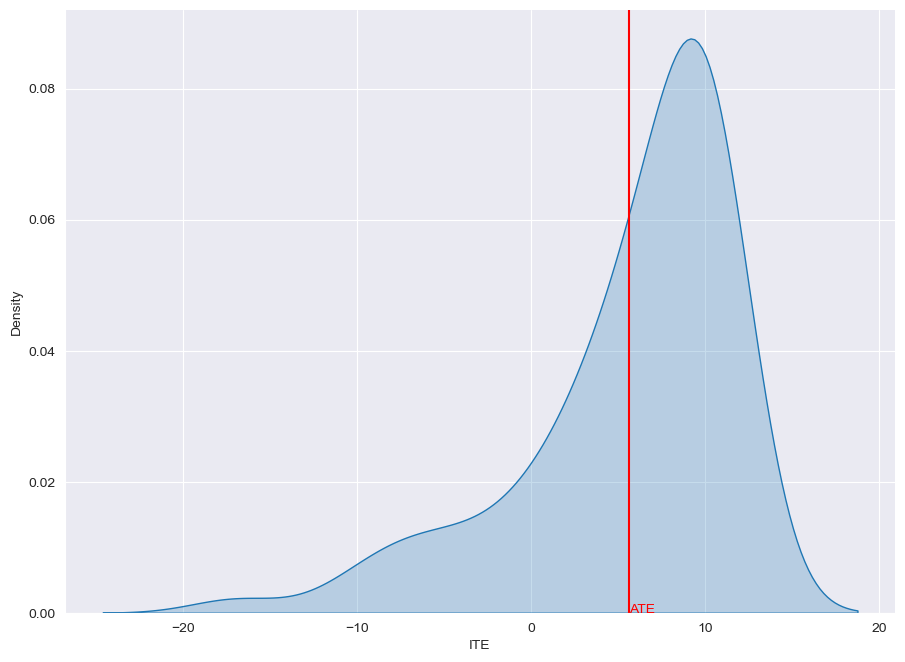

In [5]:
from causalforge.utils import plot_ite_distribution

plot_ite_distribution(dragonnet.predict_ite(x_te))

### Ground Truth 

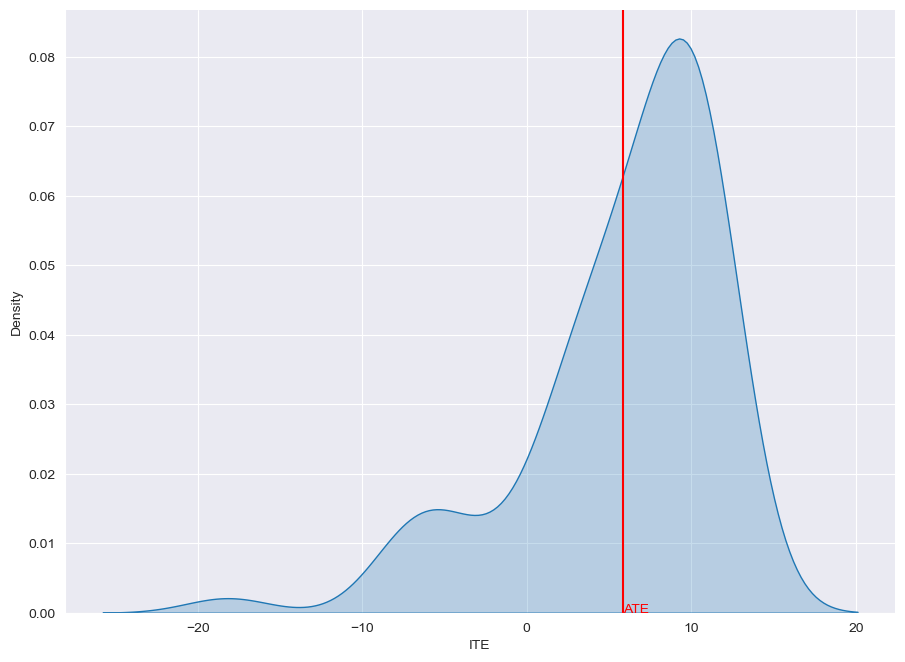

In [4]:
from causalforge.utils import plot_ite_distribution

plot_ite_distribution(ITE_truth_te)